# TITANIC - Learning from disaster
### Predicting survial or death of passengers in Titanic's database

## 1. Loading data

In [1]:
import graphlab
people_train = graphlab.SFrame('./train.csv')
people_submit = graphlab.SFrame('./test.csv')
people_submit.add_column(graphlab.SArray(
                len(people_submit)*[5]),'Survived')
people= people_submit.append(people_train)

%matplotlib inline  

graphlab.canvas.set_target('ipynb')
#people.show()
from sklearn.tree import DecisionTreeClassifier
import numpy as np
people.show()
print people

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479934456.log
INFO:graphlab.cython.cy_server:GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479934456.log


Finished parsing file /home/ubuntu/Competitions/Titanic/train.csv

Parsing completed. Parsed 100 lines in 0.017036 secs.

This non-commercial license of GraphLab Create for academic use is assigned to jafarpour@dal.ca and will expire on December 10, 2016.
------------------------------------------------------

Finished parsing file /home/ubuntu/Competitions/Titanic/train.csv

Parsing completed. Parsed 891 lines in 0.014816 secs.

Finished parsing file /home/ubuntu/Competitions/Titanic/test.csv

Parsing completed. Parsed 100 lines in 0.013744 secs.

Finished parsing file /home/ubuntu/Competitions/Titanic/test.csv

Parsing completed. Parsed 418 lines in 0.012588 secs.


Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,str,str,float,int,int,str,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,str,str,float,int,int,str,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


+-------------+--------+-------------------------------+--------+------+-------+
| PassengerId | Pclass |              Name             |  Sex   | Age  | SibSp |
+-------------+--------+-------------------------------+--------+------+-------+
|     892     |   3    |        Kelly, Mr. James       |  male  | 34.5 |   0   |
|     893     |   3    | Wilkes, Mrs. James (Ellen ... | female | 47.0 |   1   |
|     894     |   2    |   Myles, Mr. Thomas Francis   |  male  | 62.0 |   0   |
|     895     |   3    |        Wirz, Mr. Albert       |  male  | 27.0 |   0   |
|     896     |   3    | Hirvonen, Mrs. Alexander (... | female | 22.0 |   1   |
|     897     |   3    |   Svensson, Mr. Johan Cervin  |  male  | 14.0 |   0   |
|     898     |   3    |      Connolly, Miss. Kate     | female | 30.0 |   0   |
|     899     |   2    |  Caldwell, Mr. Albert Francis |  male  | 26.0 |   1   |
|     900     |   3    | Abrahim, Mrs. Joseph (Soph... | female | 18.0 |   0   |
|     901     |   3    |    

# 2. Feature Enginering

## 2.1 Creating new features: # of Cabins, Fair per Cabin, Title. It remains to be seen if these new features are useful at all

In [2]:
import graphlab.aggregate as agg
import re
# people["# of Cabins"]=map(lambda x: len(x.split()),people["Cabin"])
# people["# of Cabins"]=map(lambda x: 1 if x["# of Cabins"]==0 else x["# of Cabins"],people)

mean_fair = np.mean(people[people["Fare"]!=None]["Fare"].to_numpy())

people["Fare"] =   people["Fare"].fillna(mean_fair) 

# people["Fare per cabin"]=map(lambda x: x["Fare"]/float(x["# of Cabins"]),people)
people["Title"] =  map(lambda x:re.search('\w+,\s(\w+).', x).group(1), people["Name"])

people["HasFamily"]=map(lambda x: True if x["SibSp"] or x["Parch"] else False, people)
people["FamilySize"]=map(lambda x:x["SibSp"] + x["Parch"],people )


## 2.2 Are there any missing values -> Age, Cabin, Embarked


In [3]:

def find_missing(data):
    missing={}
    for col in data.column_names():
        num_of_missing = data[(data[col]=="") | (data[col]==None)].num_rows()
        if num_of_missing:
            missing[col]=num_of_missing   
    return missing    

print find_missing(people)

{'Age': 263, 'Cabin': 1014, 'Embarked': 2}


#### Too many Cabin information is missing (687 out of 891), so we decide to just ignore this column for our analysis



### 2.2.1 Handling Embarked missign value. Let's take a look at the distribution of this value:

In [4]:
people["Embarked"].show()

### Only two values are missing. we simply replace them with the most frequent value: "S"

In [5]:
people["Embarked"] = people["Embarked"].apply(lambda x: "S" if x=="" else x)

### 2.2.2 Missing Age values
#### we estimate the distribution of the age, and then get samples from it to replace the mssing values
#### let's see the distribution of Age based on some of the categorical features


----------------------------------------------------------------------


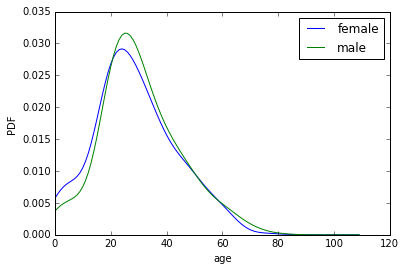

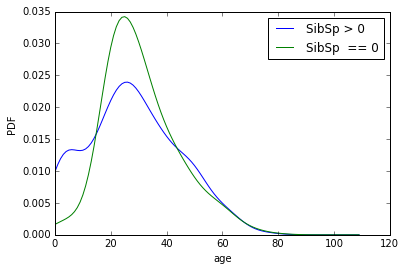

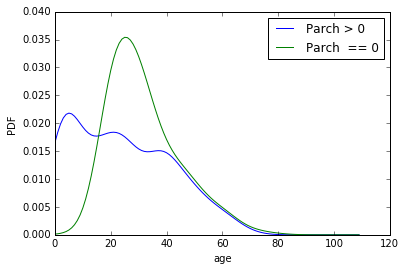

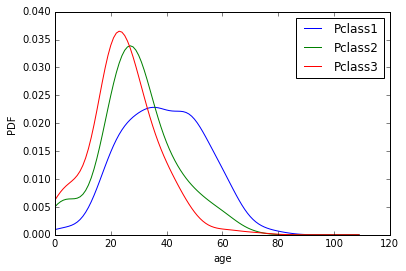

In [6]:
from sklearn.neighbors import KernelDensity
kde_female = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["Sex"]=="female"]['Age'].dropna()))
kde_male = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["Sex"]=="male"]['Age'].dropna()))
xs = range(110)
scores_female = kde_female.score_samples(map(lambda x:[x],xs))
scores_male = kde_male.score_samples(map(lambda x:[x],xs))
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline
plt.figure(1)

plt.plot(xs,np.exp(scores_female))
plt.plot(xs,np.exp(scores_male))
plt.xlabel('age')
plt.ylabel('PDF')
plt.legend(["female","male"])
plt.figure()


print "----------------------------------------------------------------------"

plt.figure(2)

kde_female = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["SibSp"]>0]['Age'].dropna()))
kde_male = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["SibSp"]<1]['Age'].dropna()))
xs = range(110)
scores_female = kde_female.score_samples(map(lambda x:[x],xs))
scores_male = kde_male.score_samples(map(lambda x:[x],xs))
plt.plot(xs,np.exp(scores_female))
plt.plot(xs,np.exp(scores_male))
plt.xlabel('age')
plt.ylabel('PDF')
plt.legend(["SibSp > 0","SibSp  == 0"])
plt.figure()

kde_female = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["Parch"]>0]['Age'].dropna()))
kde_male = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["Parch"]<1]['Age'].dropna()))
xs = range(110)
scores_female = kde_female.score_samples(map(lambda x:[x],xs))
scores_male = kde_male.score_samples(map(lambda x:[x],xs))

plt.plot(xs,np.exp(scores_female))
plt.plot(xs,np.exp(scores_male))
plt.xlabel('age')
plt.ylabel('PDF')
plt.legend(["Parch > 0","Parch  == 0"])
plt.figure()
kde_p1 = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["Pclass"]==1]['Age'].dropna()))
kde_p2 = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["Pclass"]==2]['Age'].dropna()))
kde_p3 = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people[people["Pclass"]==3]['Age'].dropna()))

xs = range(110)
plt.figure()



scores_p1 = kde_p1.score_samples(map(lambda x:[x],xs))
scores_p2 = kde_p2.score_samples(map(lambda x:[x],xs))
scores_p3 = kde_p3.score_samples(map(lambda x:[x],xs))

plt.plot(xs,np.exp(scores_p1))
plt.plot(xs,np.exp(scores_p2))
plt.plot(xs,np.exp(scores_p3))
plt.legend(["Pclass1","Pclass2","Pclass3"])
plt.xlabel('age')
plt.ylabel('PDF')
plt.figure()




In [9]:
from sklearn.neighbors import KernelDensity

def impute_age_row_complex(p):
    Survived=p['Survived']
    Pclass=p['Pclass']
    SibSp=p['SibSp']
    Parch=p['Parch']
    pid = p['PassengerId']
    kde_population_age = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people["Age"].dropna()))

    
    if p["Age"] == None:
        num_similar = np.sum(((people_with_age['Pclass']==Pclass) & (people_with_age['SibSp']==SibSp) \
                          & (people_with_age['Parch']==Parch)).to_numpy())

        if num_similar>24:
            population = people_with_age[(people_with_age['Pclass']==Pclass) & (people_with_age['SibSp']==SibSp) \
                          & (people_with_age['Parch']==Parch) ]

            kde_population_age = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],population["Age"]))
            p["Age"] = kde_population_age.sample().flatten()[0]
        else:
            p["Age"] = kde_population_age.sample().flatten()[0]
        return p
    else:
        return p

    
def impute_age_row_simple(p):
    kde_population_age = KernelDensity(kernel='gaussian', bandwidth=5).fit(map(lambda x:[x],people["Age"].dropna()))
    if p["Age"] == None:
            p["Age"] = kde_population_age.sample().flatten()[0]
    return p
    

def impute_age(people,impute_row_func):

    people_imputed_dict = map(lambda x: impute_row_func(x), people)
    people_imputed = graphlab.SFrame(people_imputed_dict).unpack("X1",column_name_prefix="")
    people_imputed.remove_columns(["Name","Ticket","Cabin"])
    return people_imputed
people_with_age = people[people["Age"]!=None]    

people_imputed = impute_age(people,impute_age_row_complex)
people_imputed
            

Age,Embarked,FamilySize,Fare,HasFamily,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
34.5,Q,0,7.8292,0,0,892,3,male,0,5,Mr
47.0,S,1,7.0,1,0,893,3,female,1,5,Mrs
62.0,Q,0,9.6875,0,0,894,2,male,0,5,Mr
27.0,S,0,8.6625,0,0,895,3,male,0,5,Mr
22.0,S,2,12.2875,1,1,896,3,female,1,5,Mrs
14.0,S,0,9.225,0,0,897,3,male,0,5,Mr
30.0,Q,0,7.6292,0,0,898,3,female,0,5,Miss
26.0,S,2,29.0,1,1,899,2,male,1,5,Mr
18.0,C,0,7.2292,0,0,900,3,female,0,5,Mrs
21.0,S,2,24.15,1,0,901,3,male,2,5,Mr


In [10]:
people_imputed["IsChild"]=map(lambda x: True if x["Age"]  <=16 else False,people_imputed)
people_imputed.show()

## 2.3 One-hot encoding for classifiers that do not accept categorical data

### 2.3.1  What are the categorical features? -> ['Embarked', 'Sex', 'Title']

In [11]:
# categorical
def find_categorical_features(data):
    features=[]
    features = filter(lambda (x,y): x==str,zip(data.column_types(),data.column_names()))
    return map(lambda (x,y): y, features)
categorical_featues = find_categorical_features(people_imputed)
print "Here is a list of Categorical features ==>", categorical_featues

Here is a list of Categorical features ==> ['Embarked', 'Sex', 'Title']


### let's do one-hot encoding on these features

In [12]:
def one_hot_encoding(people_imputed):
    people_imputed_1_hot = people_imputed.copy()
    for cat_feat in categorical_featues:
        people_imputed_1_hot[cat_feat] = people_imputed_1_hot[cat_feat].apply(lambda x: {x: 1})
        people_imputed_1_hot = people_imputed_1_hot.unpack(cat_feat)

    for column in people_imputed_1_hot.column_names():
            people_imputed_1_hot[column] = people_imputed_1_hot[column].fillna(0)
    return people_imputed_1_hot
    

        
    
people_imputed_1_hot = one_hot_encoding(people_imputed)
people_imputed_1_hot

Age,FamilySize,Fare,HasFamily,Parch,PassengerId,Pclass,SibSp,Survived,IsChild,Embarked.C,Embarked.Q
34.5,0,7.8292,0,0,892,3,0,5,0,0,1
47.0,1,7.0,1,0,893,3,1,5,0,0,0
62.0,0,9.6875,0,0,894,2,0,5,0,0,1
27.0,0,8.6625,0,0,895,3,0,5,0,0,0
22.0,2,12.2875,1,1,896,3,1,5,0,0,0
14.0,0,9.225,0,0,897,3,0,5,1,0,0
30.0,0,7.6292,0,0,898,3,0,5,0,0,1
26.0,2,29.0,1,1,899,2,1,5,0,0,0
18.0,0,7.2292,0,0,900,3,0,5,0,1,0
21.0,2,24.15,1,0,901,3,2,5,0,0,0


## even though Parch 

# 3 Bulding Predictive Models

In [13]:
features = [
 'Age',
    "FamilySize","IsChild","HasFamily",
 'Parch',
 'Pclass',
 'SibSp',
 'Embarked.C',
 'Embarked.Q',
 'Embarked.S',
 'Sex.female',
 'Sex.male',
 'Title.Capt',
 'Title.Col',
 'Title.Don',
 'Title.Dr',
 'Title.Jonkheer',
 'Title.Lady',
 'Title.Major',
 'Title.Master',
 'Title.Miss',
 'Title.Mlle',
 'Title.Mme',
 'Title.Mr',
 'Title.Mrs',
 'Title.Ms',
 'Title.Rev',
 'Title.Sir',
 'Title.the']

target =  'Survived'


## 3.1 Decision Tree Classifier

### 3.1.1 Traning and Evaluation (Accuracy ~= 82.6%)
We use 10-fild cross validation for evaluation of the the Decision Tree Classifier

In [161]:
people_submit = people_imputed_1_hot[people_imputed_1_hot["Survived"]==5]
people_train = people_imputed_1_hot[people_imputed_1_hot["Survived"]!=5]

from sklearn.cross_validation import cross_val_score
tree = DecisionTreeClassifier(min_samples_leaf=10,max_depth=4)
scores = cross_val_score(tree, people_train[features].to_numpy(), people_train[target].to_numpy(), cv=10)
np.mean(scores)

0.82263023493360576

### 3.1.2 What are important features? How about the ones we created?

accuracy -> 0.77245508982
[(0.0019206818301695729, 'IsChild'), (0.0066218237502939587, 'Embarked.S'), (0.0077366607731837022, 'Parch'), (0.018738424569226739, 'Embarked.Q'), (0.040923055672443275, 'Sex.female'), (0.094630183370808751, 'FamilySize'), (0.10362512451480922, 'Age'), (0.16470486463292336, 'Pclass'), (0.56109918088614141, 'Title.Mr')]


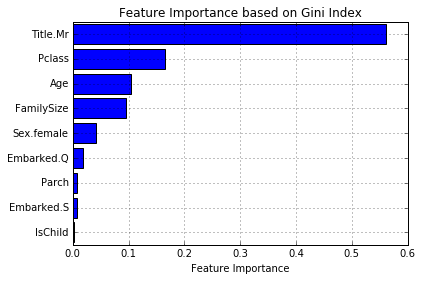

In [46]:
train_data, test_data = people_train.random_split(.8)
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(min_samples_leaf=10)
tree.fit(train_data[features].to_numpy(), train_data[target].to_numpy())
# map(lambda x:tree.predict(x),test_data.to_numpy())

test_survived = test_data["Survived"]

test_data_minus_survived = test_data.copy()
test_data_minus_survived.remove_column("Survived")
print "accuracy ->", sum(tree.predict(test_data_minus_survived[features].to_numpy()) == test_survived) / float(len(test_survived))
#feature_importance_sframe = graphlab.SFrame(sr)
feature_importancec = graphlab.SFrame({'faeture':features,'importance':tree.feature_importances_})
feature_importancec.sort("importance",ascending = False)
#!/usr/bin/env python
# make a horizontal bar chart

feature_importance = zip(tree.feature_importances_,features)
important_feature_importance = sorted(filter(lambda x:x[0] > 0, feature_importance))
important_features = map(lambda x:x[1],important_feature_importance)


print important_feature_importance

from pylab import *
val = map(lambda x:x[0],important_feature_importance)    # the bar lengths
pos = arange(len(important_feature_importance))+.5    # the bar centers on the y axis

figure(1)
barh(pos,val, align='center')
yticks(pos,important_features )
xlabel('Feature Importance')
title('Feature Importance based on Gini Index')
grid(True)
show()


## 3.2 Ensemble Learning -> Accuracy = 83.7


In [158]:
from sklearn.ensemble import GradientBoostingClassifier 
ensemble = GradientBoostingClassifier(learning_rate=0.1)
scores = cross_val_score(ensemble, people_train[features].to_numpy(), people_train[target].to_numpy(), cv=10)
mean(scores)

0.82380376801725119

## 3.3 KNN


### 3.3.1 Training and Evaluation 

In [157]:

from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=10,weights='distance')
scores = cross_val_score(knn, people_train[features].to_numpy(), people_train[target].to_numpy(), cv=10)
mean(scores)

0.79353989331517416

## 3.3.2 Does using vector scaling help? Noo!

In [124]:
data = people_train[features].to_numpy()
data_scaled=map(lambda x: x/sqrt(np.dot(x,x)),data)
scores = cross_val_score(knn, data_scaled, people_train[target].to_numpy(), cv=10)
mean(scores)

0.7778603450232664

## 3.4 Random Forest

In [159]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100,max_depth=5)
scores = cross_val_score(random_forest, people_train[features].to_numpy(), people_train[target].to_numpy(), cv=10)
mean(scores)

0.83276784700942008

## 3.5 Ridge Regression

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score 

lr_train,lr_test = people_train.random_split(.8)

lr = linear_model.Ridge(fit_intercept =True,alpha=.01)
pnf  = PolynomialFeatures(degree=2)

this_input  = pnf.fit_transform(lr_train[features].to_numpy())
this_test = pnf.fit_transform(lr_test[features].to_numpy())

lr.fit(this_input,lr_train[target].to_numpy())
predictions = lr.predict(this_test)<0

print accuracy_score(predictions,lr_test[target].to_numpy())

# 4 Predictions

## 4.1 Ensemble

In [154]:
ensemble.fit(people_train[features].to_numpy(), people_train[target].to_numpy())
predictions = ensemble.predict(people_submit[features].to_numpy())

pid_prediction = graphlab.SFrame({'PassengerId':people_submit["PassengerId"],'Survived':predictions})
pid_prediction["PassengerId","Survived"].export_csv("ensemble.csv")

## 4.2 Random Forst

### 4.2.1 Manual

In [21]:
random_forest.fit(people_train[features].to_numpy(), people_train[target].to_numpy())
predictions = random_forest.predict(people_submit[features].to_numpy())
pid_prediction = graphlab.SFrame({'PassengerId':people_submit["PassengerId"],'Survived':predictions})
pid_prediction["PassengerId","Survived"].export_csv("random_forest.csv")

### Grid search function

In [60]:
from itertools import product
def GridSearchCVBorna(clfmodel,param_grid = param_grid,cv=5):
    parameters=[]
    for key in param_grid.keys():
        print key
        max_mean=-10
        best_param=[]
        this_set=[]
        values=param_grid[key]
        for val in values:   
            this_set.append((key,val))
        parameters.append(this_set)     
        
    for pcombination in product(*parameters):
        pdict = dict(pcombination)
        clf = clfmodel(**pdict)
        scores = cross_val_score(clf, people_train[features].to_numpy(), people_train[target].to_numpy(), cv=cv)
        this_mean= mean(scores)
        print this_mean
        if this_mean > max_mean:
            max_mean=this_mean
            best_param=pdict
    return best_param

### 4.2.2 Grid Search

In [162]:
#from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3,4,5,6, None],
              "max_features": [1, 3,5, 10],
              "min_samples_split": [1,5, 3, 10],
              "min_samples_leaf": [1, 5,3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators":[100]}

# run grid search
best_random_forest = GridSearchCVBorna(RandomForestClassifier, param_grid=param_grid,cv=10)
best_random_forest.fit(people_train[features].to_numpy(), people_train[target].to_numpy())
predictions = best_random_forest.predict(people_submit[features].to_numpy())
pid_prediction = graphlab.SFrame({'PassengerId':people_submit["PassengerId"],'Survived':predictions})
pid_prediction["PassengerId","Survived"].export_csv("random_forest_best_params_cv10.csv")

bootstrap
min_samples_leaf
n_estimators
min_samples_split
criterion
max_features
max_depth
0.80484082397
0.824927647259
0.830520655998
0.830508171604
0.777923901941
0.815875326297
0.828273464987
0.833878958121
0.832755362615
0.779008909318
0.820408012711
0.830533140393
0.832767847009
0.829409544887
0.78578907048
0.830520372262
0.832755362615
0.831631767109
0.829422029282
0.784602201793
0.814789467711
0.826063727159
0.832755362615
0.829397060493
0.777873113154
0.817074963114
0.831631767109
0.835002553626
0.832755362615
0.77899670866
0.822680456248
0.832767847009
0.832767847009
0.831644251504
0.783541595733
0.831656735898
0.831656735898
0.830508171604
0.830533140393
0.789147372602
0.811455850641
0.827162353876
0.831644251504
0.831631767109
0.801431733061
0.810269833163
0.827137101351
0.833878958121
0.836126149132
0.802567812961
0.818160537964
0.831656735898
0.833878958121
0.833878958121
0.796899897855
0.829422029282
0.831656735898
0.829422029282
0.829434513676
0.801432016797
0.8136528203

AttributeError: 'dict' object has no attribute 'fit'